# Vertical Regridding
Author: [Jason Boutte](https://github.com/jasonb5)

Date: 01/25/23

Related APIs:

* [xarray.Dataset.regridder.vertical](../generated/xarray.Dataset.regridder.vertical.rst)

The data used in this example can be found through the [Earth System Grid Federation (ESGF) search portal](https://aims2.llnl.gov/search).

## Overview
We'll cover vertical regridding using `xgcm`.

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import xarray as xr
import xcdat

## 1. Open the Dataset
We are using xarray's OPeNDAP support to read a netCDF4 dataset file directly from its source. The data is not loaded over the network until we perform operations on it (e.g., temperature unit adjustment).

More information on the xarray's OPeNDAP support can be found [here](https://docs.xarray.dev/en/stable/user-guide/io.html#opendap).

In [3]:
filepath = '../../xcdat_test_data/T_185001_201312.nc'

ds = xcdat.open_dataset(filepath, chunks={})

ds = ds.isel(time=slice(0, 100))

ds

<xarray.Dataset>
Dimensions:    (lat: 129, lon: 256, nbnd: 2, time: 100, lev: 72, bnds: 2)
Coordinates:
  * lat        (lat) float64 -90.0 -88.59 -87.19 -85.78 ... 87.19 88.59 90.0
  * lon        (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
  * lev        (lev) float64 0.1238 0.1828 0.2699 0.3986 ... 986.2 993.8 998.5
  * time       (time) object 1850-02-01 00:00:00 ... 1858-05-01 00:00:00
Dimensions without coordinates: nbnd, bnds
Data variables:
    lat_bnds   (lat, nbnd) float64 dask.array<chunksize=(129, 2), meta=np.ndarray>
    lon_bnds   (lon, nbnd) float64 dask.array<chunksize=(256, 2), meta=np.ndarray>
    gw         (lat) float64 dask.array<chunksize=(129,), meta=np.ndarray>
    area       (lat, lon) float64 dask.array<chunksize=(129, 256), meta=np.ndarray>
    P0         float64 ...
    PS         (time, lat, lon) float32 dask.array<chunksize=(100, 129, 256), meta=np.ndarray>
    T          (time, lev, lat, lon) float32 dask.array<chunksize=(100, 72, 129, 256), meta=np.ndarray>
    hyam       (lev) float64 dask.array<chunksize=(72,), meta=np.ndarray>
    hybm       (lev) float64 dask.array<chunksize=(72,), meta=np.ndarray>
    time_bnds  (time, nbnd) object dask.array<chunksize=(100, 2), meta=np.ndarray>
    lev_bnds   (lev, bnds) float64 0.09432 0.1533 0.1533 ... 996.1 1.001e+03
Attributes: (12/18)
    ne:                        30
    np:                        4
    Conventions:               CF-1.0
    source:                    CAM
    case:                      20180215.DECKv1b_H1.ne30_oEC.edison
    title:                     UNSET
    ...                        ...
    time_period_freq:          month_1
    history:                   Tue Aug 28 20:02:34 2018: ncks -t 2 -O --no_tm...
    NCO:                       netCDF Operators version 4.7.6 (Homepage = htt...
    nco_openmp_thread_number:  2
    map_file:                  /p/cscratch/acme/data/map_ne30np4_to_fv129x256...
    input_file:                /p/user_pub/e3sm/baldwin32/deck/v1_DECK_histor...

## 2. Create the output grid
Related API: [xcdat.create_grid()](../generated/xcdat.create_grid.rst)

In this example, we will generate a grid with half the levels.

In [4]:
output_grid = xcdat.create_grid(lev=ds.lev[::2])

output_grid

<xarray.Dataset>
Dimensions:   (lev: 36, bnds: 2)
Coordinates:
  * lev       (lev) float64 0.1238 0.2699 0.5885 1.283 ... 958.0 977.3 993.8
Dimensions without coordinates: bnds
Data variables:
    lev_bnds  (lev, bnds) float64 0.05076 0.1969 0.1969 ... 985.5 1.002e+03

## 3. Regridding using the `linear` method
Related API: [xarray.Dataset.regridder.vertical()](../generated/xarray.Dataset.regridder.vertical.rst)

Here we will regrid the input data to the output grid using the `xgcm` tool and the `linear` method. 

We'll interpolate temperature onto the new vertical grid.

/opt/conda/envs/xcdat_dev/lib/python3.10/site-packages/xgcm/grid.py:987: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
2023-01-26 03:39:41,027 [WARNING]: bounds.py(_create_bounds:396) >> The 'lat' coordinate variable is missing a 'units' attribute. Assuming 'units' is 'degrees_north'.


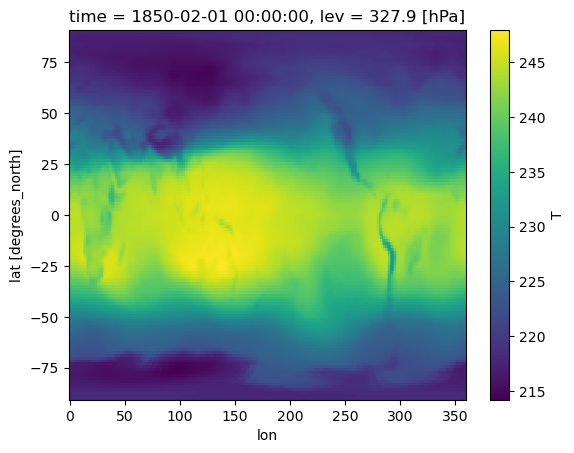

In [18]:
output = ds.regridder.vertical('T', output_grid, tool='xgcm', method='linear')

output.T.isel(time=0, lev=20).plot()

## 4. Regridding 
Related API: [xarray.Dataset.regridder.vertical()](../generated/xarray.Dataset.regridder.vertical.rst)

Here we will regrid the input data to the output grid using the `xgcm` tool and the `linear` method.

We'll interpolate temperature onto surface pressure.

/opt/conda/envs/xcdat_dev/lib/python3.10/site-packages/xgcm/grid.py:987: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
2023-01-26 03:38:56,386 [WARNING]: bounds.py(_create_bounds:396) >> The 'lat' coordinate variable is missing a 'units' attribute. Assuming 'units' is 'degrees_north'.


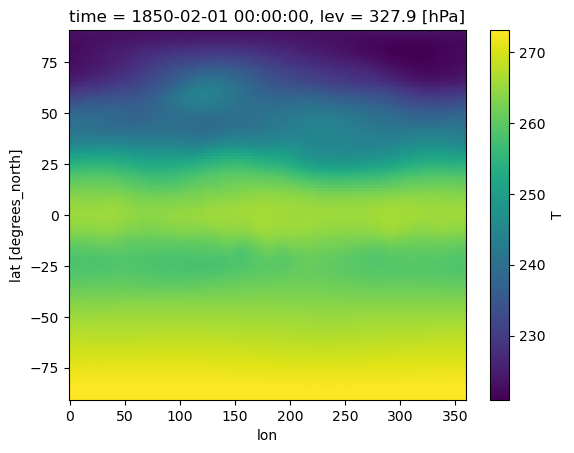

In [16]:
def atmosphere_hybrid_sigma_pressure_coordinate(a, b, p0, ps):
    return a * p0 + b * ps

terms = ds.cf.formula_terms["lev"]

terms = {x: ds[y] for x, y in terms.items()}

ds["pressure"] = atmosphere_hybrid_sigma_pressure_coordinate(**terms)

output = ds.regridder.vertical('T', output_grid, tool='xgcm', method='linear', target_data="pressure")

output.T.isel(time=0, lev=20).plot()

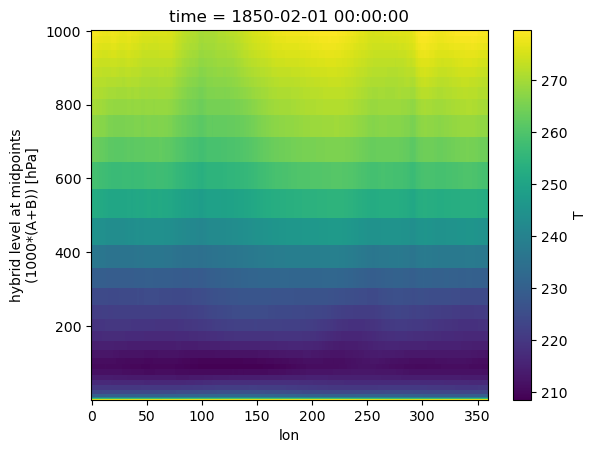

In [21]:
output.T.isel(time=0).mean(dim='lat').plot(x='lon')